In [1]:
import networkx as nx
import csv
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable
from networkx.algorithms import community
from networkx import to_numpy_matrix
from networkx import edge_betweenness_centrality 
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt
from mpl_toolkits.basemap import Basemap as Basemap
import pprint as pp
import heapq
from scipy.cluster import hierarchy
from scipy.spatial import distance

%matplotlib inline

This class initialise :
 - The Global Trade Network over years in a given period
as a directed graph called graphs
 - The Centrality table over years as a dictionary called country_centralities
 - The period we extract data from comtrade file called period
 - threshold to reduce node and edge

In [15]:
data_total_goods = 'data/automotive_2008-2017_trade.csv'
data_intermediate_goods = 'data/automotive_2008-2017_trade_intermediate.csv'
data_finish_goods = 'data/automotive_2008-2017_trade_finish.csv'

period = list(map(str,range(2008,2018)))
period[-1]


'2017'

In [4]:
# TODO order method
# TODO see if method should be function
# TODO class and method description


class gpn:
    """ 
    Object of this class return a dictionary with year as keys and a network 
    as value.
    Each network is characterized by country as node and trade export as 
    edge.
    Each edge is directed and have as attribute:
    -the export as weight
    -TODO the betweeness centrality as 'betweeness'
    Each node country have as attribute:
    - its total export as total_export 
    -TODO its pagerank degree of centrality as 'centrality'
    Available methode:
    - add_threshold(self,country_treshold=None,export_treshold=None, 
    compute_centrality=True):
        Reduce the number of significant country in the network and cut non 
        significant edge. Compute_centrality compute new centrality value.
    TODO finish description
    
    """
    
    def __init__(self, comtrade_file, period, thresholds,
                 *indexs, **kwargs):
        self.period = list(map(str, period)) 
        self.comtrade_file = comtrade_file
        self.thresholds = thresholds
        self.pos_data = pd.read_csv("countries_codes_and_coordinates.csv")
        if len(indexs) == 4:
            time_index, importer_index, exporter_index, quantity_index = \
                indexs
        else:
            time_index, importer_index, exporter_index, quantity_index = \
                0, 1, 2, 3
        self.graphs, self.countries_export, self.countries_import = \
            self._initialize_graphs(
                time_index, importer_index, exporter_index, quantity_index
            )
        
        self.world_export = {
            year: self.graphs[year].size(weight='weight') 
            for year in self.period
        }
        self.average_export = {
            year: self.world_export[year]/len(G.nodes) 
            for year, G in self.graphs.items()
        }
        self.centrality_df = self.compute_centrality_df(
            self.graphs, self.period
        )
        self.countries = {year:list(G.nodes) for year,G in self.graphs.items()}

    def _initialize_graphs(self, time_index, importer_index, exporter_index,
                           quantity_index):
        """
        :param time_index: 
        :param importer_index: 
        :param exporter_index: 
        :param quantity_index: 
        :return: 
        """
        graphs = {year: nx.DiGraph() for year in self.period}
        with open(self.comtrade_file, 'r') as csvfile:
            csv_f = csv.reader(csvfile,delimiter='|')
            next(csv_f)
            for row in csv_f:
                if row[time_index] in self.period:
                    if float(row[quantity_index]) != 0:
                        graphs[str(row[time_index])].add_edge(
                            row[importer_index].upper(), row[exporter_index].upper(), weight=float(
                                row[quantity_index]
                            )
                    )
        graphs = self._select_nodes(graphs, self.pos_data['ISO_3'])
        return self._compute_nodes_attributes(graphs, self.period)
    
    @staticmethod     
    def _select_nodes(graphs, standard_list):
        """
        :param graphs: 
        :param standard_list: 
        :return: 
        """
        for year, G in graphs.items():
            to_remove = list(set(G.nodes)-set(standard_list))
            graphs[year].remove_nodes_from(to_remove)
        return graphs
      
    @staticmethod     
    def _compute_nodes_attributes(graphs, period):
        """
        :param graphs: 
        :param period: 
        :return: 
        """
        countries_export = {year: dict() for year in period}
        countries_import = {year: dict() for year in period}
        for year, G in graphs.items():
            countries_export[year] = dict()
            # Calculate total exports of each country in the network
            for country in G.nodes():
                country_export, country_import = 0, 0
                exportation = [
                    attributes for out_country, in_country, attributes 
                    in G.out_edges(country, data=True)
                ]
                importation = [
                    attributes for out_country, in_country, attributes 
                    in G.in_edges(country, data=True)
                ]
                for attributes in exportation: 
                    for weight in attributes.values():
                        country_export += float(weight)
                for attributes in importation: 
                    for weight in attributes.values():
                        country_import += float(weight)
                countries_export[year][country] = country_export
                countries_import[year][country] = country_import
                nx.set_node_attributes(
                    graphs[year], countries_export[year], name='total_export'
                )
            pagerank_centrality = nx.pagerank_numpy(G, weight='weight'
                                                    )
            nx.set_node_attributes(
                graphs[year], pagerank_centrality, name='centrality'
            )
        return graphs, countries_export, countries_import
    
    
    # TODO add to graphs
    @staticmethod
    def _compute_edge_centrality(graphs):
        """
        :param graphs: 
        :return: 
        """
        for year, graph in graphs:
            edge_betweenness_year = nx.edge_betweenness_centrality(
                graph, weight='weight'
            )
            nx.set_edge_attributes(graphs[year],
                                   edge_betweenness_year,
                                   'betweenness_centrality'
                                   )
        return graphs
    
    def compute_centrality_df(self, graph, period=None,
                              centrality_type='pagerank'):
        """
        :param graph: 
        :param period: 
        :param centrality_type: 
        :return: 
        """
        if not period:
            period = self.period
        centrality = dict()
        for year in period:
            pagerank_centrality = self.choose_centrality(centrality_type,
                                                         graph[year],
                                                         weight='weight'
                                                         )
            centrality[year] = pagerank_centrality 
        centrality_table = pd.DataFrame(data=centrality)
        return centrality_table
    
    def centrality_to_csv(self, centrality='pagerank', period=None):
        """
        :param centrality: 
        :param period: 
        :return: 
        """
        if not period:
            period = self.period
        centrality_table_csv = self.compute_centrality_df(
            self.graphs, period, centrality)
        name = '{type}_centrality_{begin}_{end}.csv'.format(
            type=centrality, begin=period[0], end=period[-1])
        centrality_table_csv.to_csv(name)
        return
    # TODO add centality choice
    # TODO formated title per centrality
    def plot_centrality(self, player_number,
                        save=False, year_ref=None):
        """
        :param player_number: 
        :param save: 
        :param year_ref: 
        :return: 
        """
        if not year_ref:
            year_ref = self.period[0]
        biggest_player = self.centrality_df.nlargest(player_number, year_ref)
        plt.plot(biggest_player.transpose())
        name ='Country_centrality_{begin}-{end}'.format(
            begin=self.period[0], end=self.period[-1])
        plt.title(name)
        plt.xlabel('year')
        plt.ylabel('Page rank centrality')
        plt.legend(biggest_player.index,
                   bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
        plt.show()
        if save:
            plt.savefig('Page_rank_centrality_20122016.png')
    
    def distance_shortest_path(self,G):
        path_length = nx.all_pairs_shortest_path_length(G)
        distances = np.zeros((len(G), len(G)))
        for u, p in path_length:
            for v, d in p.items():
                distances[u][v] = d
        return distances
    # BUG distance matrix kernel is not symetric it cannot work
    # with current distance
#     def create_hc(self, G = None):
#         """
#         Creates hierarchical cluster of graph G from distance matrix
#         """
#         # last year graph by default
#         if not G:
#             G = self.graphs[self.period[-1]]
#         G = nx.convert_node_labels_to_integers(G)
#         distances = self.distance_shortest_path(G)

#         # Create hierarchical cluster
#         Y = distance.squareform(distances)
#         Z = hierarchy.complete(Y)  # Creates HC using farthest point linkage
#         # This partition selection is arbitrary, for illustrive purposes
#         membership = list(hierarchy.fcluster(Z, t=1.15))
#         # Create collection of lists for blockmodel
#         partition = defaultdict(list)
#         for n, p in zip(list(range(len(G))), membership):
#             partition[p].append(n)
#         return list(partition.values())
#     # TODO rename
    def clustering(self, year=None, iteration=4, graphs=None):
        """
        :param year: 
        :param iteration: 
        :param graphs: 
        :return: 
        """
        if not year:
            year = self.period[-1]
        if not graphs:
            graphs = self.graphs
        G = graphs[year]
        comp = community.girvan_newman(
            G, most_valuable_edge=self.most_central_edge
        )
        for _ in range(iteration):
            countries_cluster = tuple(sorted(cluster) for cluster in next(comp))
        return countries_cluster
        
    # TODO check better centrality 
    @staticmethod
    def choose_centrality(centrality, graph, weight='weight'):
        """
        :param centrality: 
        :param graph: 
        :param weight: 
        :return: 
        """
        return {
             'degree': nx.degree_centrality(graph),
            'in_degree': nx.in_degree_centrality(graph),
            'out_degree': nx.out_degree_centrality(graph),
            'eigenvector': nx.eigenvector_centrality_numpy(
                graph, weight=weight),
            'betweenness': nx.betweenness_centrality(graph, weight=weight),
            'pagerank': nx.pagerank_numpy(graph, weight=weight),
            'closeness': nx.closeness_centrality(graph)
        }.get(centrality, lambda: None)
    
    # TODO use edge attributes instead to reduce clustering computation
    @staticmethod
    def most_central_edge(G):
        """
        :param G: 
        :return: Compute edge_betweenness_centrality,  normalized it then get 
        the key with the maximum value
        """
        edge_betweenness = nx.edge_betweenness_centrality(G, weight='weight')
        max_centrality = max(edge_betweenness.values())
        edge_betweenness_normalized = {
            edge: centrality / max_centrality for edge, centrality 
            in edge_betweenness.items()
        }
        return max(
            edge_betweenness_normalized, key=edge_betweenness_normalized.get
        )
    
    # TODO create policies for thresholds
    def add_threshold(self, country_threshold=None, export_threshold=None):
        """
        :param country_threshold: 
        :param export_threshold: 
        :return: 
        """
        for year, G in self.graphs.items():
            if export_threshold:
                edges_to_remove = list()
                for out_country, in_country in G.out_edges():  
                    if (G[out_country][in_country]['weight'] < 
                            G.nodes[out_country]['total_export'] *
                            export_threshold):
                        edges_to_remove.append((out_country, in_country))
                self.graphs[year].remove_edges_from(edges_to_remove)

            if country_threshold:
                nodes_to_remove = list()
                for country in G.nodes():
                    if (G.nodes[country]['total_export'] <=
                            self.world_export[year] * country_threshold):
                        nodes_to_remove.append(country)
                self.graphs[year].remove_nodes_from(nodes_to_remove)
                
    def agency_matrix(self):
        """
        :return: 
        """
        agency_matrix = dict()
        for year, G in self.graphs.items():
            # order node by total export
            nodelist = sorted(
                G.nodes(data=True), key=lambda x: x[1]['total_export'],
                reverse=True
            )
            nodelist = [x[0] for x in nodelist]
            agency_matrix[year] = to_numpy_matrix(
                G, nodelist=nodelist,  weight='weight', nonedge=0
            )
        return agency_matrix
    
    def similarity(self, n = None):
        self.world_export
        self.countries_export,
        self.countries_import
        sim ={year:
              {country:{
                  trade:{} 
                  for trade in ['import','export']}  
               for country in self.countries[year]} 
              for year in self.period}
        
        for year, G in self.graphs.items():
            for out_country in self.countries[year]:
                for in_country in self.countries[year]:
                    if out_country != in_country:
                        try:
                            sim[year][out_country]['export'][in_country] = float(
                                G[out_country][in_country]['weight']/
                                self.countries_export[year][out_country]
                            )
                        except (KeyError, ZeroDivisionError):
                            pass
                        try:
                            sim[year][out_country]['import'][in_country] = float(
                                G[in_country][out_country]['weight']/
                                self.countries_import[year][out_country]
                            )
                        except (KeyError, ZeroDivisionError):
                            pass
        if n:
            nlargest = dict()
            for year in self.period:
                nlargest[year] = dict()
                for country in sim[year]:
                    nlargest[year][country] = dict()
                    for trade in ['export','import']:
                        nlargest[year][country][trade] = dict()
                        try:
                            for key,value  in sim[year][country][trade].items():
                                for val in heapq.nlargest(n,sim[year][country][trade].values()):
                                    if val == value and val != 0.0:
                                        nlargest[year][country][trade][key] = value
                        except KeyError:
                            nlargest[year][country][trade] = sim[year][country][trade]
            return nlargest
        return sim
    
    # TODO add other 'part' of the world than EU
    # TODO fill country following clustering
    # TODO maybe color for edge centrality, cleaner edge in general
    # TODO method or function
    # TODO same scale of color zithout doubling centrality value
    def show_map(self, year=None, part=None, save=False, dpi=300):
        """
        :param year: 
        :param save: 
        :param dpi: 
        :param part: 'EU', ..
        :return: 
        """
        if not year:
            year = self.period[-1]
        G = self.graphs[year]
        plt.figure(figsize=(20, 10))
        
        if part:
            scale = 60
            coord = {'EU': {'x1': -10, 'x2': 60, 'y1': 30, 'y2': 64,
                            'espg': 3035
                            }
                     }.get(part)
            
            m = Basemap(width=12000000, height=9000000, resolution='l',
                        projection='robin',
                        llcrnrlat=coord['y1'], urcrnrlat=coord['y2'],
                        llcrnrlon=coord['x1'], urcrnrlon=coord['x2'], 
                        lat_ts=(coord['x1']+coord['x2'])/2,
                        lat_0=(coord['x1']+coord['x2'])/2,
                        lon_0=(coord['y1']+coord['y2'])/2,
                        epsg=coord['espg']
                        )
        else:
            scale = 30
            m = Basemap(resolution='l', projection='robin', lon_0=0)
            
        m.drawmapboundary(fill_color='#46bcec')
        m.drawcountries(linewidth=0.2)
        m.fillcontinents(color='#f2f2f2', lake_color='#ADD8E6')
        m.shadedrelief(scale=0.2)
        position_data = self.pos_data[
            self.pos_data['ISO_3'].isin(list(G.nodes))
        ]

        mx, my = m(position_data['Longitude'].values,
                   position_data['Latitude'].values
                   )
        pos = {}
        for count, elem in enumerate(position_data['ISO_3']):
            pos[elem] = (mx[count], my[count])
            
        # Use the results later for the node's size in the graph
        node_size = [float(G.nodes[v]['total_export'])*scale /
                     self.average_export[year] 
                     for v in G
                     ]
        edge_size = [float(G[u][v]['weight']*(scale/10)/
                           self.average_export[year]) 
                     for (u, v) in G.edges()
                     ]
        node_color = [float(G.node[v]['centrality'])*2 for v in G]

        
        # Draw nodes
        nodes = nx.draw_networkx_nodes(G, pos, node_size=node_size,
                                       node_color=node_color, alpha=0.4
                                       ) 
        # Draw edges
        edges = nx.draw_networkx_edges(G, pos, edge_color='lightgray'
                                       , arrows=True, arrowsize=5,
                                       width=edge_size, alpha=0.6
                                       )

        # Add labels
        nx.draw_networkx_labels(G, pos, font_size=5)
        nodes.set_edgecolor('gray')
        # Bar with color scale for eigenvalues
        cbar = plt.colorbar(mappable=nodes, cax=None, ax=None,
                            fraction=0.015, pad=0.04
                            )
        cbar.set_clim(min(node_color), max(node_color))
        
        plt.tight_layout()
        plt.show()
        
        if save:
            plt.savefig("map_1.png", format="png", dpi=dpi)


    
    


## Initialisation of the object

In [16]:
gpn_car = gpn(data_total_goods, period, None, 0,1,2,3)
gpn_car_intermediate = gpn(data_intermediate_goods, period, None, 0,1,2,3)
gpn_car_finish = gpn(data_finish_goods, period, None, 0,1,2,3)

# gpn_car_threshold = gpn(data, period, None)
# gpn_car_threshold.add_threshold(country_threshold=0.0005, export_threshold= 0.05)
# # gpn_car.centrality_to_csv(centrality='pagerank')
print(gpn_car.world_export['2008']/10**9)
print(gpn_car_intermediate.world_export['2008']/10**9)
print(gpn_car_finish.world_export['2008']/10**9)



1126.94541505364
298.6996231603097
828.2457918933302


In [7]:
gpn_car.centrality_to_csv(centrality='pagerank')
# gpn_car_intermediate.centrality_to_csv(centrality='pagerank')
# gpn_car_finish.centrality_to_csv(centrality='pagerank')

In [10]:
# print(gpn_car.graphs['2017'].nodes)
gpn_car_finish.centrality_df.nlargest(20,'2017')

2008      2009      2010      2011      2012      2013      2014  \
USA  0.058172  0.058929  0.056901  0.056015  0.076388  0.061711  0.066977   
DEU  0.053720  0.067967  0.050367  0.047427  0.042765  0.036787  0.041999   
CAN  0.024348  0.025967  0.025142  0.022477  0.028245  0.023983  0.026187   
CHN  0.012384  0.031206  0.018721  0.023534  0.018656  0.026310  0.034843   
FRA  0.040704  0.058507  0.039854  0.037266  0.030636  0.028880  0.035645   
GBR  0.032117  0.033032  0.030039  0.028734  0.024875  0.029341  0.028645   
GHA  0.001403  0.001737  0.025015  0.010557  0.008880  0.008247  0.002817   
KOR  0.003093  0.004766  0.003696  0.003998  0.012580  0.005779  0.005760   
CMR  0.001389  0.001460  0.004281  0.002031  0.002365  0.001931  0.004259   
ITA  0.030033  0.037374  0.025005  0.022044  0.017237  0.016573  0.017829   
AUS  0.014215  0.011737  0.013005  0.014338  0.017957  0.018528  0.014835   
ESP  0.022996  0.024622  0.021918  0.012756  0.009905  0.009393  0.012576   
SDN  0.011010  0.011464  0.010857  0.010187  0.008771  0.002261  0.004456   
SEN  0.002326  0.003331  0.003915  0.012879  0.005406  0.006603  0.004801   
NLD  0.011671  0.012836  0.012422  0.011246  0.010599  0.009635  0.011371   
CHL  0.003975  0.007928  0.005457  0.007492  0.007780  0.009638  0.005495   
MEX  0.008201  0.007423  0.006949  0.008233  0.009816  0.009585  0.009630   
RUS  0.058384  0.014751  0.019706  0.025531  0.039027  0.033079  0.023613   
MMR  0.000876  0.001363  0.002036  0.001875  0.001535  0.001846  0.002245   
SAU  0.019787  0.016593  0.014906  0.017040  0.019182  0.018100  0.022314   

         2015      2016      2017  
USA  0.077314  0.084859  0.091589  
DEU  0.048643  0.053600  0.052425  
CAN  0.030871  0.034367  0.038299  
CHN  0.029299  0.036673  0.032925  
FRA  0.035043  0.032130  0.031321  
GBR  0.034447  0.037326  0.031057  
GHA  0.002039  0.012657  0.023501  
KOR  0.007537  0.010588  0.022225  
CMR  0.008426  0.002461  0.021943  
ITA  0.021579  0.021220  0.020772  
AUS  0.015318  0.013803  0.017231  
ESP  0.016521  0.015634  0.015627  
SDN  0.011706  0.003766  0.014714  
SEN  0.007018  0.006168  0.014418  
NLD  0.011953  0.020453  0.013288  
CHL  0.018357  0.012527  0.013250  
MEX  0.010295  0.011508  0.013105  
RUS  0.010275  0.012103  0.012445  
MMR  0.002060  0.005993  0.011276  
SAU  0.029080  0.019834  0.010752

## Similarities of countries

In [127]:
# # 
# similarity = gpn_car.similarity(6)
# for year in list(map(str,range(2012,2017))):
#     print(year+': ')
#     pp.pprint(similarity[year]['DEU'])
# # pp.pprint(gpn_car.countries_export)
# pp.pprint(gpn_car.countries_import)
# df = gpn_car.centrality_df.loc[['DEU','USA','CHN'],:].transpose()
# df


ABW           AFG           AGO         AIA           ALB  \
2008   1034923.73  7.899422e+05  1.733248e+06  1332108.00  2.918476e+06   
2009   8894581.44  1.767755e+08  1.970651e+07  1358820.30  4.820748e+08   
2010  18443790.07  9.863244e+06  1.547095e+08   616931.91  5.631971e+06   
2011  28215080.18  2.438290e+05  7.964007e+06   290067.73  2.056530e+07   
2012  19104734.02  1.918161e+06  3.116885e+06   175698.20  1.757367e+07   
2013   3035065.62  6.458193e+05  2.177373e+06   454869.00  2.048505e+07   
2014   4218052.36  5.440801e+06  6.370400e+06   389044.00  2.433821e+07   
2015   6562411.35  4.646268e+05  4.136319e+06   200731.00  2.694199e+07   
2016   3229689.82  3.034475e+06  6.233668e+06   141315.63  3.304635e+07   
2017   4519472.44  1.369843e+06  4.176048e+06   382095.57  3.359924e+07   

              AND         ANT           ARE           ARG          ARM  \
2008   7881837.28  2144493.69  5.567343e+09  6.521221e+09   1957308.57   
2009  18406545.70  2640702.08  5.733586e+08  5.403455e+09   3237341.18   
2010  11128720.41  3881250.96  7.568775e+08  8.017913e+09   1272433.30   
2011   4921151.89         NaN  1.407624e+09  1.017361e+10  10547792.57   
2012  11472760.70         NaN  7.616023e+08  9.739000e+09   4043339.92   
2013  10671703.19         NaN  1.441190e+09  1.016886e+10   2075622.26   
2014   9689099.38         NaN  1.071679e+10  8.412469e+09   2968641.22   
2015   3821061.80         NaN  7.500770e+08  6.043793e+09   7521306.30   
2016   6391312.97         NaN  5.853722e+09  5.150211e+09  13411203.64   
2017  10951936.35         NaN  6.201948e+08  5.818618e+09  14002374.16   

         ...               VEN          VGB           VNM        VUT  \
2008     ...       98271353.48   3057781.20  5.618808e+08   37101.00   
2009     ...       30761662.07   3773784.68  4.974030e+08   23642.89   
2010     ...       27988492.90   2647770.44  7.667311e+08  138658.61   
2011     ...       23580823.85   2351867.56  9.146334e+08   88591.19   
2012     ...       10874941.16   3541143.55  1.045110e+09   50730.44   
2013     ...        8249764.00   2525955.97  1.523157e+09  303133.10   
2014     ...        5850253.00  13401649.00  1.860746e+09  176118.00   
2015     ...        5770016.13   1873914.62  1.951100e+09   43479.83   
2016     ...        8774543.41  13024323.63  2.037344e+09   14899.00   
2017     ...        8830864.37  21035215.26  2.018497e+09  191300.00   

            WLF         WSM           YEM           ZAF          ZMB  \
2008   58702.01    39278.00  3.576089e+06  7.595330e+09  19117485.86   
2009   35803.57   134108.69  5.668989e+07  5.581224e+09  39731709.32   
2010   15818.00  1267064.57  1.582736e+07  6.607070e+09  16318165.62   
2011       0.00  2917138.42  1.878985e+07  7.855857e+09  16995329.74   
2012   23248.66  6994390.40  1.544628e+07  7.900399e+09  27131948.84   
2013   32068.00   342020.77  2.012900e+06  7.753524e+09  77681879.16   
2014    7746.00   255164.22  2.659976e+08  7.289005e+09  75601861.60   
2015  106315.00   385498.50  6.363839e+07  7.217900e+09  38076033.71   
2016       0.00   153280.10  1.663850e+05  8.382470e+09  11656971.81   
2017    1878.00   447014.23  6.184700e+04  8.718346e+09  15925748.55   

              ZWE  
2008  68874139.16  
2009   9630568.48  
2010   8678687.44  
2011   6092937.50  
2012   8676304.00  
2013   8139166.30  
2014   6631566.61  
2015   9069681.77  
2016   3666242.91  
2017   3266205.26  

[10 rows x 221 columns]

In [ ]:
df = gpn_car.centrality_df

ax = df.plot(x="date", y="column1", legend=False)
ax2 = ax.twinx()
df.plot(x="date", y="column2", ax=ax2, legend=False, color="r")
ax.figure.legend()
plt.show()

In [ ]:
gpn_car = gpn(data_total_goods, period, None, 0,1,2,3)
gpn_car_intermediate = gpn(data_intermediate_goods, period, None, 0,1,2,3)
gpn_car_finish = gpn(data_finish_goods, period, None, 0,1,2,3)

# gpn_car_threshold = gpn(data, period, None)
# gpn_car_threshold.add_threshold(country_threshold=0.0005, export_threshold= 0.05)


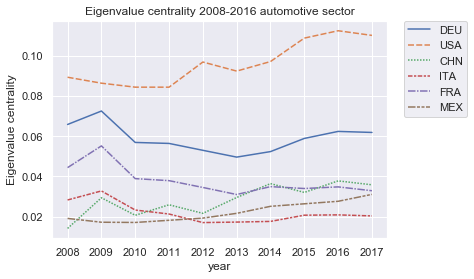

In [11]:
import seaborn as sns
sns.set(style="darkgrid")
df = gpn_car.centrality_df.loc[['DEU','USA','CHN','ITA','FRA','MEX'],:].transpose()
sns.lineplot(data=df, color="g")
plt.title('Eigenvalue centrality 2008-2016 automotive sector')
plt.xlabel('year')
plt.ylabel('Eigenvalue centrality')
plt.legend(df.columns, bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.show()

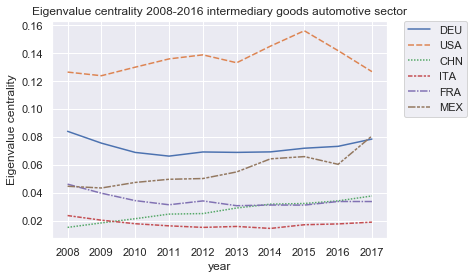

In [377]:
import seaborn as sns
sns.set(style="darkgrid")
df = gpn_car_intermediate.centrality_df.loc[['DEU','USA','CHN','ITA','FRA','MEX'],:].transpose()
sns.lineplot(data=df, color="g")
plt.title('Eigenvalue centrality 2008-2016 intermediary goods automotive sector')
plt.xlabel('year')
plt.ylabel('Eigenvalue centrality')
plt.legend(df.columns, bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.show()

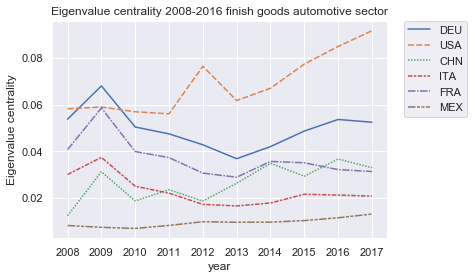

In [378]:
import seaborn as sns
sns.set(style="darkgrid")
df = gpn_car_finish.centrality_df.loc[['DEU','USA','CHN','ITA','FRA','MEX'],:].transpose()
sns.lineplot(data=df, color="g")
plt.title('Eigenvalue centrality 2008-2016 finish goods automotive sector')
plt.xlabel('year')
plt.ylabel('Eigenvalue centrality')
plt.legend(df.columns, bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.show()

In [314]:
df_trade = pd.DataFrame(gpn_car.countries_export)
df_trade = df_trade
df_trade = df_trade.loc[['DEU','USA','CHN','ITA','FRA','MEX'],:].transpose()
df_trade = df_trade.multiply(10**-9)
sns.set(style="darkgrid")
# df = gpn_car.centrality_df.loc[['DEU','USA','CHN'],:].transpose()
# sns.lineplot(data=df_trade, color="g")
# plt.title('test')
# plt.xlabel('year')
# plt.ylabel('total trades')
# plt.legend(df_trade.columns, bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)

plt.show()

In [54]:
df_odi_tot['CHN ODI DEU'].iloc[:-1].loc[df.index != 2018]

year
2008       0.0
2009       0.0
2010       0.0
2011     520.0
2012       0.0
2013     400.0
2014     640.0
2015    1270.0
2016     760.0
2017    2610.0
Name: CHN ODI DEU, dtype: float64

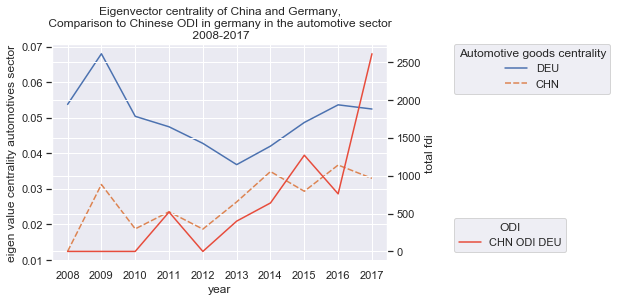

In [55]:
df_g = gpn_car_finish.centrality_df.loc[['DEU','CHN'],:].transpose()
df_odi = pd.read_excel('data/China-Global-Investment-Tracker-2019-Spring-FINAL.xlsx', sheet_name='deu_odi',dtype={'year': str, 'A':float,'CHN ODI DEU': float}).set_index('year')
df_odi_tot = df_odi.loc[:,'CHN ODI DEU'].to_frame()
df_odi_tot = df_odi_tot.iloc[:-1].loc[df.index != 2018]
sns.set(style="darkgrid")
ax = sns.lineplot(data=df_g, legend=False, color="r")

plt.title('Eigenvector centrality of China and Germany,\n Comparison to Chinese ODI in germany in the automotive sector \n 2008-2017')
plt.xlabel('year')
plt.ylabel('eigen value centrality automotives sector')
plt.legend(df_g.columns,title="Automotive goods centrality", bbox_to_anchor=(1.2, 1), loc=2, borderaxespad=0.)
ax2 = ax.twinx()
sns.lineplot(data=df_odi_tot,ax=ax2, legend=False, palette = sns.color_palette(["#e74c3c"]))
plt.ylabel('total fdi')
plt.legend(df_odi_tot.columns,title="ODI", bbox_to_anchor=(1.2, 0.2), loc=2, borderaxespad=0.)

# ax.figure.legend()

plt.show()

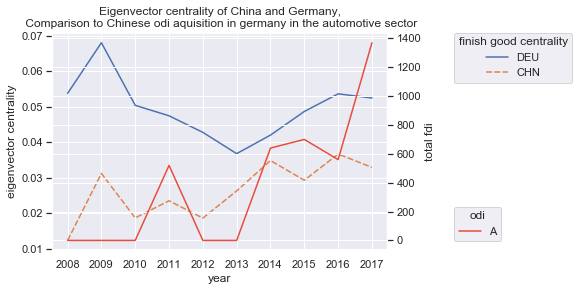

In [63]:
df_g = gpn_car_finish.centrality_df.loc[['DEU','CHN'],:].transpose()
df_odi = pd.read_excel('data/China-Global-Investment-Tracker-2019-Spring-FINAL.xlsx', sheet_name='deu_odi',dtype={'year': str, 'A':float,'CHN ODI DEU': float}).set_index('year')
df_odi_aq = df_odi.loc[:,'A'].to_frame().loc[df.index != 2018]
sns.set(style="darkgrid")
ax = sns.lineplot(data=df_g, legend=False, color="r")

plt.title('Eigenvector centrality of China and Germany,\n Comparison to Chinese odi aquisition in germany in the automotive sector')
plt.xlabel('year')
plt.ylabel('eigenvector centrality')
plt.legend(df_g.columns,title="finish good centrality", bbox_to_anchor=(1.2, 1), loc=2, borderaxespad=0.)
ax2 = ax.twinx()
sns.lineplot(data=df_odi_aq,ax=ax2, legend=False, palette = sns.color_palette(["#e74c3c"]))
plt.ylabel('total fdi')
plt.legend(df_odi_aq.columns,title="odi", bbox_to_anchor=(1.2, 0.2), loc=2, borderaxespad=0.)

# ax.figure.legend()

plt.show()

In [ ]:
df_g = gpn_car_finish.centrality_df.loc[['DEU','CHN'],:].transpose()
df_odi = pd.read_excel('data/China-Global-Investment-Tracker-2019-Spring-FINAL.xlsx', sheet_name='deu_odi',dtype={'year': str, 'CHN_ODI_DEU': float}).set_index('year')
sns.set(style="darkgrid")
ax = sns.lineplot(data=df_g, legend=False, color="r")

plt.title('test')
plt.xlabel('year')
plt.ylabel('total trades')
plt.legend(df_g.columns,title="finish good centrality", bbox_to_anchor=(1.2, 1), loc=2, borderaxespad=0.)
ax2 = ax.twinx()
sns.lineplot(data=df_odi['total'],ax=ax2, legend=False, palette = sns.color_palette(["#e74c3c"]))
plt.ylabel('total fdi')
plt.legend(df_odi.columns,title="odi", bbox_to_anchor=(1.2, 0.2), loc=2, borderaxespad=0.)

# ax.figure.legend()

plt.show()

In [394]:
import numpy.ma as ma
def crosscorr(datax, datay, lag=0, wrap=False):
    """ Lag-N cross correlation. 
    Shifted data filled with NaNs 
    
    Parameters
    ----------
    lag : int, default 0
    datax, datay : pandas.Series objects of equal length
    Returns
    ----------
    crosscorr : float
    """

    if wrap:
        shiftedy = datay.shift(lag)
        shiftedy.iloc[:lag] = datay.iloc[-lag:].values
        return datax.corr(shiftedy)
    else: 
        return datax.corr(datay.shift(lag))
d1 = df_odi_tot['CHN ODI DEU']
d2 = gpn_car_finish.centrality_df.loc[['DEU'],:].transpose()
d2 = d2['DEU']
rs = [crosscorr(d2,d1, lag) for lag in range(0,4)]
rs

[-0.02772838907390932,
 0.05601987243925037,
 0.38867655965056697,
 0.4530656701517811]

In [247]:
a = [15, 12, 8, 8, 7, 7, 7, 6, 5, 3]
b = [10, 25, 17, 11, 13, 17, 20, 13, 9, 15]
from scipy.stats import linregress
print(linregress(d1, d2).rvalue)
print(np.corrcoef(d1, d2))

d1.corr(d2)
np.ceil(len(rs)/2)

0.03615947325962685
[[1.         0.03615947]
 [0.03615947 1.        ]]


0.5140311145421977

In [396]:
d1 = df_odi_tot['CHN ODI DEU']
d2 = gpn_car_finish.centrality_df.loc[['DEU'],:].transpose()
d2 = d2['DEU']
from statsmodels.tsa.stattools import adfuller
X = d2
result = adfuller(X)
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])
print('Critical Values:')
for key, value in result[4].items():
    print('\t%s: %.3f' % (key, value))

ADF Statistic: -1.746214
p-value: 0.407473
Critical Values:
	1%: -4.939
	5%: -3.478
	10%: -2.844


[-0.02772838907390932, 0.05601987243925037, 0.38867655965056697, 0.4530656701517811]


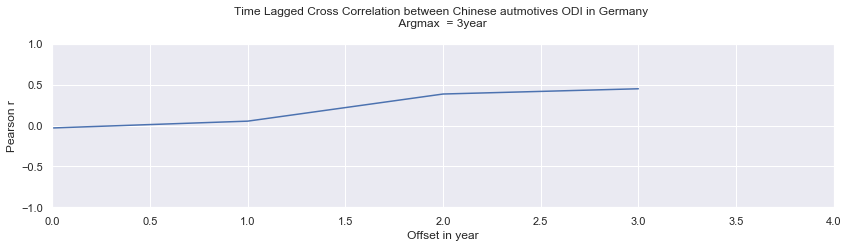

In [397]:
def crosscorr(datax, datay, lag=0, wrap=False):
    """ Lag-N cross correlation. 
    Shifted data filled with NaNs 
    
    Parameters
    ----------
    lag : int, default 0
    datax, datay : pandas.Series objects of equal length
    Returns
    ----------
    crosscorr : float
    """
    if wrap:
        shiftedy = datay.shift(lag)
        shiftedy.iloc[:lag] = datay.iloc[-lag:].values
        return datax.corr(shiftedy)
    else: 
        return datax.corr(datay.shift(lag))

d1 = df_odi_tot['CHN ODI DEU']
d2 = gpn_car_finish.centrality_df.loc[['DEU'],:].transpose()
d2 = d2['DEU']

rs = [crosscorr(d2,d1, lag) for lag in range(0,4)]
print(rs)
offset = np.argmax(rs)
f,ax=plt.subplots(figsize=(14,3))
ax.plot(rs)
ax.set(title=f'Time Lagged Cross Correlation between Chinese autmotives ODI in Germany \n Argmax  = {offset}year \n',ylim=[-1,1],xlim=[0,4], xlabel='Offset in year',ylabel='Pearson r')
plt.show()

[-0.012421388563191553, 0.061091169659853554, 0.24154389584101382, 0.17015281352747338]


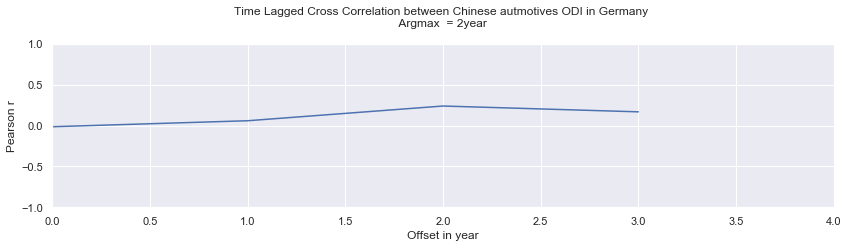

In [398]:
d1 = df_odi_aq['A']
d2 = gpn_car_finish.centrality_df.loc[['DEU'],:].transpose()
d2 = d2['DEU']

rs = [crosscorr(d2,d1, lag) for lag in range(0,4)]
print(rs)
offset = np.argmax(rs)
f,ax=plt.subplots(figsize=(14,3))
ax.plot(rs)
ax.set(title=f'Time Lagged Cross Correlation between Chinese autmotives ODI in Germany \n Argmax  = {offset}year \n',ylim=[-1,1],xlim=[0,4], xlabel='Offset in year',ylabel='Pearson r')
plt.show()

In [375]:
a = gpn_car_finish.graphs['2017']
print(a['MEX']['USA'])
b = gpn_car_intermediate.graphs['2017']
print(b['MEX']['USA'])
c = gpn_car_finish.graphs['2016']
print(c['USA']['MEX'])
d = gpn_car_intermediate.graphs['2016']
print(d['USA']['MEX'])

{'weight': 60238623894.240005}
{'weight': 23123807966.93}
{'weight': 4852207114.070001}
{'weight': 14011377581.770002}


# Data visualisation

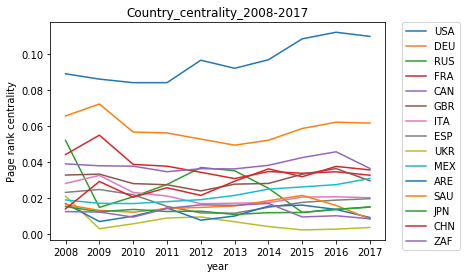

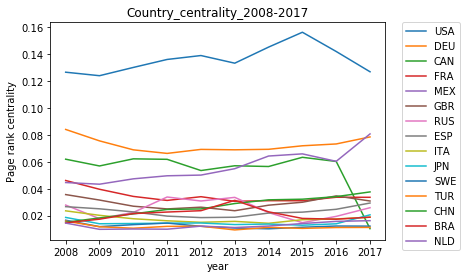

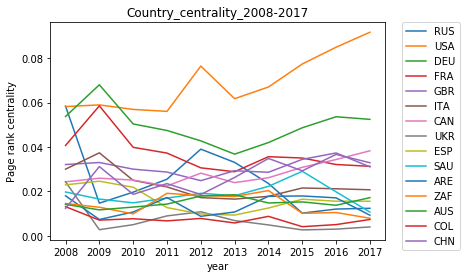

In [108]:
gpn_car.plot_centrality(15)
gpn_car_intermediate.plot_centrality(15)
gpn_car_finish.plot_centrality(15)

In [353]:
period = range(2008,2018)
period[-1]
gpn_car = gpn(data_total_goods, period, None, 0,1,2,3)
gpn_car_intermediate = gpn(data_intermediate_goods, period, None, 0,1,2,3)
gpn_car_finish = gpn(data_finish_goods, period, None, 0,1,2,3)


In [358]:
def tradetot(cy):
    totg = gpn_car.countries_export
    print(totg['2017'][cy]/10**9)
    inter = gpn_car_intermediate.countries_export
    print(inter['2017'][cy]/10**9)
    finish = gpn_car_finish.countries_export
    print(finish['2017'][cy]/10**9)
tradetot('MEX')

105.64807940090994
27.649751630430004
77.99832777048005


# map visualisation

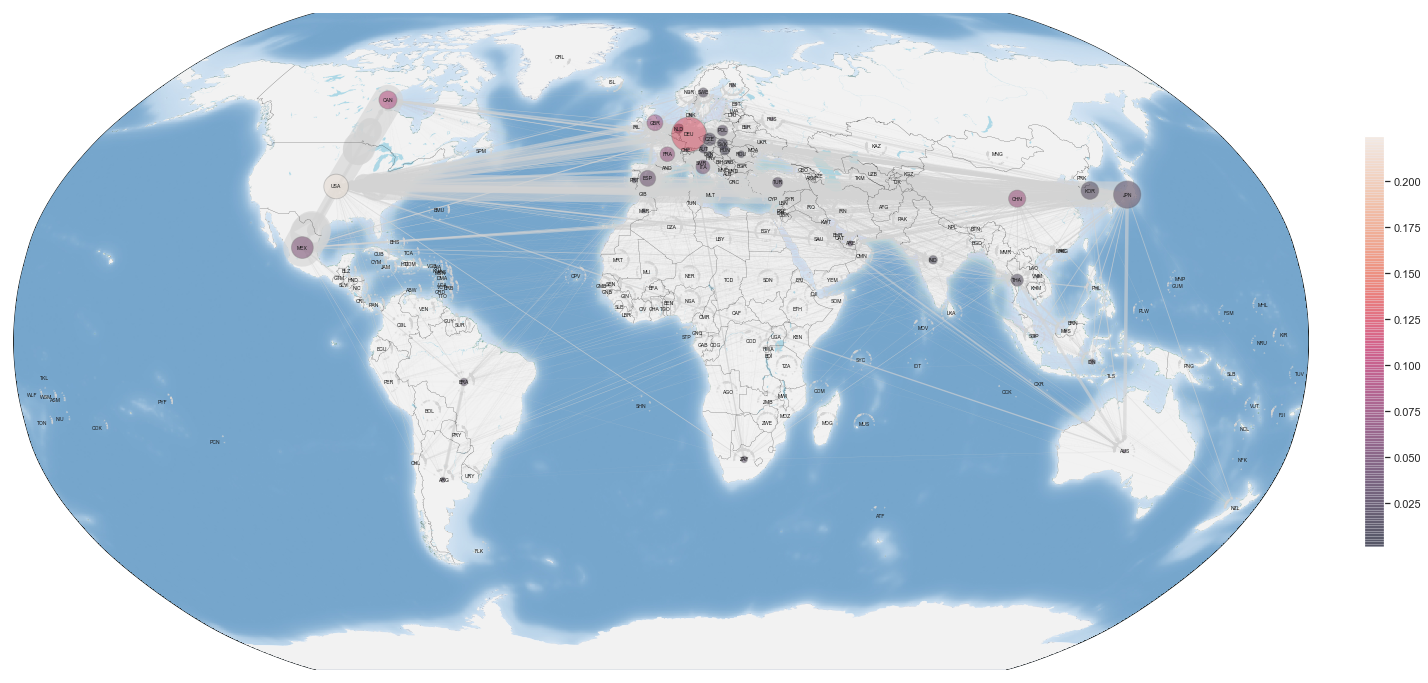

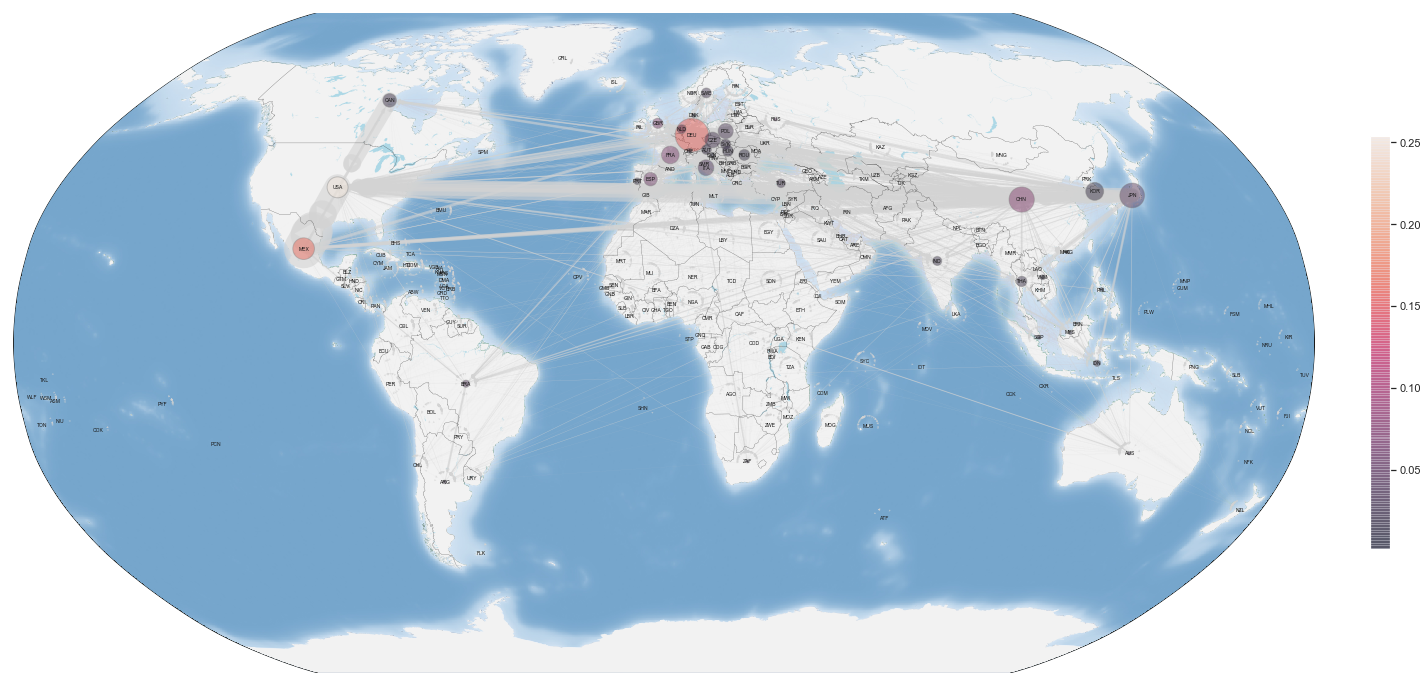

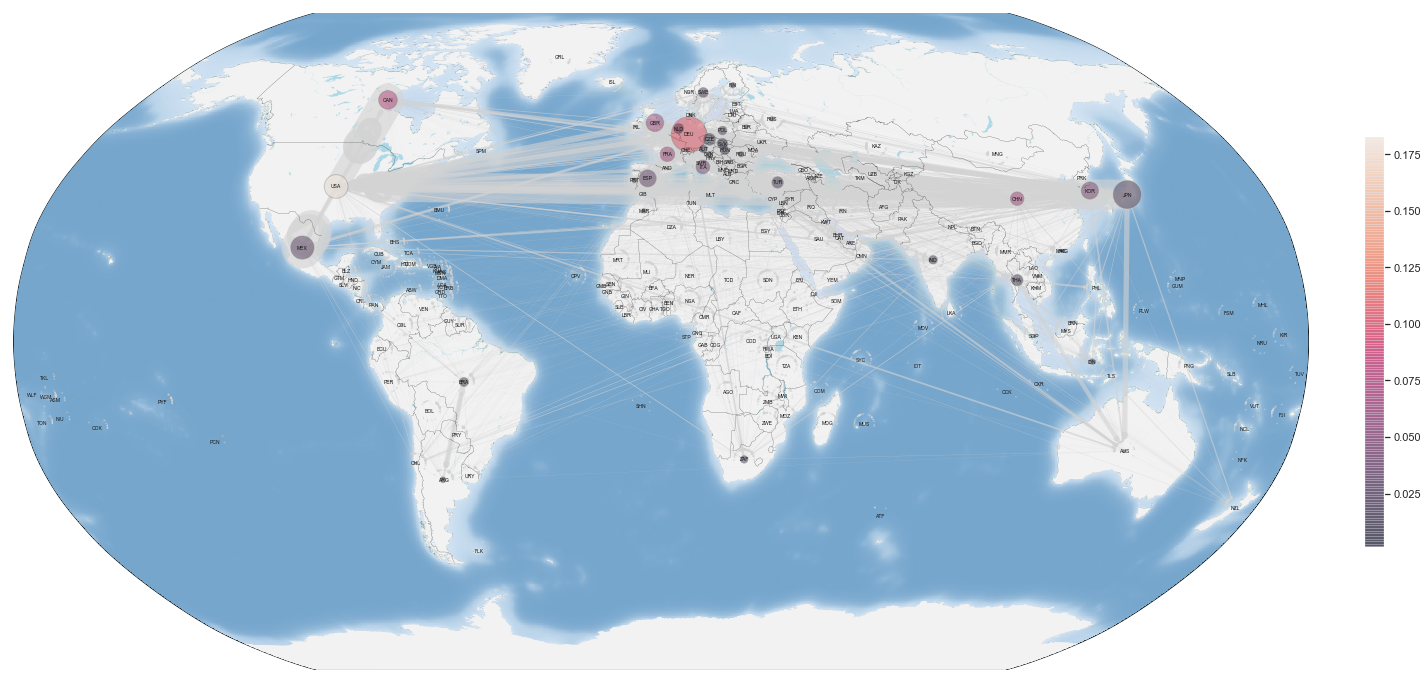

In [342]:

# gpn_car_threshold = gpn(data, period, None)
# gpn_car_threshold.add_threshold(country_threshold=0.0005, export_threshold= 0.05)

gpn_car.show_map()
gpn_car_intermediate.show_map()
gpn_car_finish.show_map()

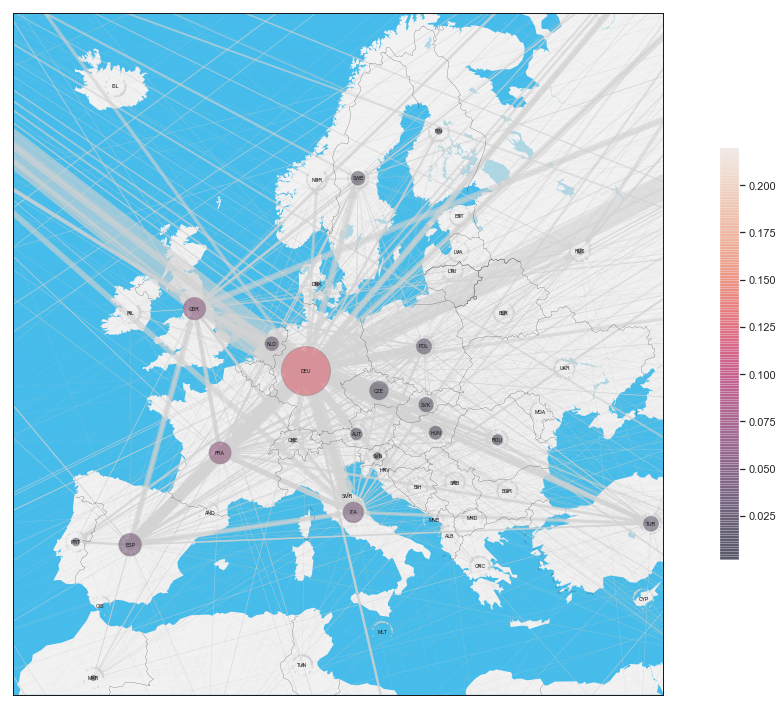

In [65]:
gpn_car.show_map(part='EU',year='2017')


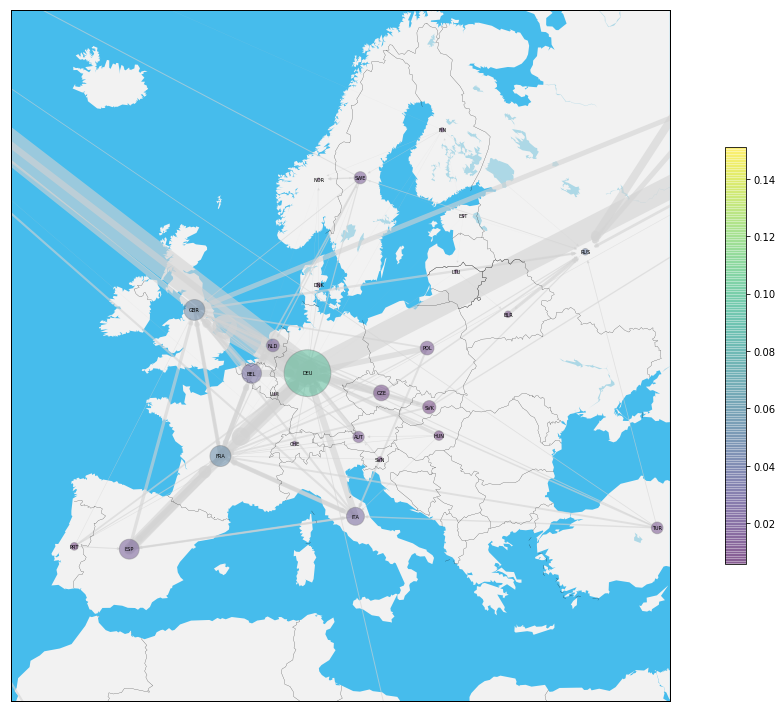

In [142]:
gpn_car_threshold.show_map(part='EU',year='2012')

# Clustering
We test a girvan_newman clustering algoritm ( based on edge betweeness) with 4 iteration by default

In [68]:
print('Clustering 2012:')
pp.pprint(gpn_car_threshold.clustering('2012'))

print('Clustering 2016:')
pp.pprint(gpn_car_threshold.clustering('2016'))



Clustering 2012:
(['AUT',
  'CAN',
  'CHE',
  'CZE',
  'DEU',
  'ESP',
  'FRA',
  'GBR',
  'HUN',
  'ITA',
  'POL',
  'PRT',
  'RUS',
  'SVK',
  'SVN',
  'TUR',
  'USA',
  'ZAF'],
 ['BEL', 'DNK', 'FIN', 'LUX', 'NLD', 'NOR', 'SWE'],
 ['AUS', 'CHN', 'IDN', 'JPN', 'KOR', 'SGP', 'THA', 'VNM'],
 ['ARG', 'BRA', 'CHL', 'MEX'],
 ['BLR', 'EST', 'LTU'])
Clustering 2016:
(['DNK', 'EST', 'FIN', 'LUX', 'NLD', 'NOR', 'SWE'],
 ['AUS',
  'CHN',
  'IDN',
  'JPN',
  'KOR',
  'KWT',
  'MYS',
  'QAT',
  'SAU',
  'SGP',
  'THA',
  'USA',
  'VNM'],
 ['AUT',
  'BEL',
  'CHE',
  'CZE',
  'DEU',
  'ESP',
  'FRA',
  'GBR',
  'HUN',
  'ITA',
  'MAR',
  'POL',
  'PRT',
  'SVK',
  'SVN',
  'TUR',
  'ZAF'],
 ['ARG', 'BRA', 'CAN', 'CHL', 'IND', 'MEX'],
 ['BLR', 'LTU', 'RUS'])


# Hierachical clustering
Objectif find a way to make the matrix symmetric

In [65]:
gpn_car_threshold.create_hc()

ValueError: Distance matrix 'X' must be symmetric.

Note:
Free-energy  p 124 
adjusted rand indecrand index
article
Clustering hierachic


a bag of of paths framework for network data analysis
Development in the theory in the theory of randomized shortest paths with a comparaison of graph node distances
A 


In [69]:
agency = gpn_car.agency_matrix()
agency['2013']

matrix([[0.00000000e+00, 7.00046773e+06, 3.35478225e+07, ...,
         3.79900000e+01, 3.53090000e+01, 0.00000000e+00],
        [2.68855742e+06, 0.00000000e+00, 4.94301982e+07, ...,
         2.72173800e+03, 0.00000000e+00, 1.07336000e+02],
        [5.79195013e+06, 1.44996107e+06, 0.00000000e+00, ...,
         4.29655800e+03, 0.00000000e+00, 1.05253000e+02],
        ...,
        [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
         0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
        [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
         0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
        [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
         0.00000000e+00, 0.00000000e+00, 0.00000000e+00]])

In [128]:
def free_energy_distance(agency_matrix, cost_matrix, theta=1, absorbing_path=1, varargin):
    """
    :params: agency_matrix is a square adjacency positive matrix of a strongly connected graph
    non connected edge have an infinite distance 
    :params: cost_matrix is a positive matrix 
    :params: theta must lie between eps (= 0.00000001) and 50.0.
    If theta is close to 0, we obtain the expected cost between  i and j.
    If theta = infinity, we obtain the shortest-path kernel.
    :params: absorbing_path is a binary 1 if we are using absorbing paths,
    0 if we are using non-absorbing paths.
    """
    # check variable
    if len(agency_matrix) != len(agency_matrix[0]) and len(set(map(len, agency_matrix))) != 1:
        raise AttributeError('The matrix must be square') 
    if agency_matrix.shape != cost_matrix.shape:
        raise ValueError('The adjacency and cost matrices do not have the same dimension.')
    if theta < 0 or theta > 50.0:
        raise ValueError(f'The value of theta is out of the admissible range [0:50.0].')
    
    # initialise
    n = len(agency_matrix)
    e = np.ones([n, 1])
    l = np.identity(n)
    
    # transition probabilities matrix
    transition_probabilities_matrix = agency_matrix.copy()
    s = np.sum(transition_probabilities_matrix, 1,)
    transition_probabilities_matrix = transition_probabilities_matrix/(s@e.conj().T)
    
    # Computation of the W matrix
    W = np.exp(-theta @ cost_matrix) * transition_probabilities_matrix
    
    # Computation of the Z matrix
    
    return free_energy_distance_matrix.

SyntaxError: invalid syntax (<ipython-input-128-2cbdabc72f2d>, line 35)

In [70]:
import os
from IPython.display import Javascript as d_js

def to_format(type='pdf', code = False):
    d_js(
        "IPython.notebook.kernel.execute('name = \"' + IPython.notebook.notebook_name + '\"')"
    )

    if not code:
        with open("hidecode.tplx", "w") as text_file:
            text_file.write("""
             ((*- extends 'article.tplx' -*))
            ((* block input_group *))
            ((*- if cell.metadata.get('nbconvert', {}).get('show_code', False) -*))
            ((( super() )))
            ((*- endif -*))
            ((* endblock input_group *))
            """)
        hidecode ='--template hidecode'
    else:
        hidecode =''
    os.system(f"jupyter nbconvert --to {type} {hidecode} {name}")  
    try:
        os.remove("hidecode.tplx")
    except FileNotFoundError:
        pass
    
to_format()

In [71]:
os.remove("hidecode.tplx")

FileNotFoundError: [WinError 2] Le fichier spécifié est introuvable: 'hidecode.tplx'